<Axes: >

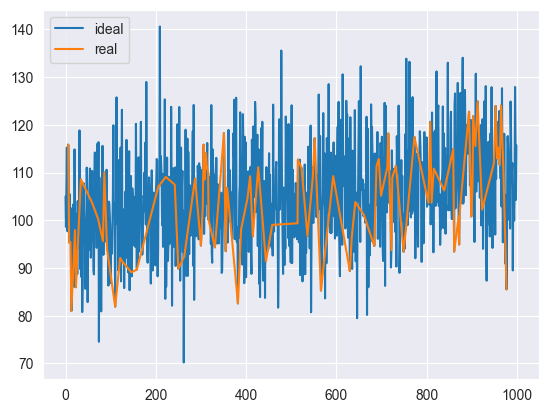

In [91]:
# 为判断算法有效性并直观反映算法效果，先生成一个理想股价时间序列，即等间距、高密度的（t, Pt）序列
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)
ideal_timestamps = np.arange(0, 1000, 1)
ideal_prices = np.random.normal(100, 10, 1000)+np.arange(0, 1000, 1)/100
# 然后随机生成一个真实的股价时间序列
real_timestamps = ideal_timestamps[np.sort(np.random.randint(0, 1000, 100))]
real_prices = ideal_prices[real_timestamps]

sns.set_style("darkgrid")
sns.lineplot(x=ideal_timestamps, y=ideal_prices, label="ideal")
sns.lineplot(x=real_timestamps, y=real_prices, label="real")

# 用这一组数据来测试算法


SMA:  104.03157050579217


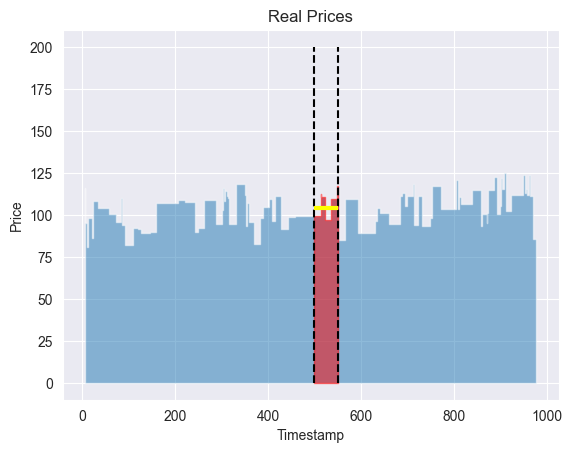

In [92]:
# 先考虑（t, Pt）尚未超出内存限制的情况。例如在len(real_timestamps)==100的情况下，设置内存上限为num_bins=50
# 在这种情况下，只需要根据实际数据，计算[t-W, t]时间段内的平均价格

# 首先考虑如何在该种情况下合理计算MovingAverage
# 由于只需要进行SMA，且“假设在相邻两次数据到达期间内，股票的真实价格都等于前一次数据的价格”，因此可以考虑以积分的方式定义SMA
# 直观地看，首先绘制real_prices相对于real_timestamps的图像，其中在real_timestamps[i]和real_timestamps[i+1]之间的区域，其取值均为real_prices[i]
# 当给定[t-W, t]时，可以通过计算该区域的面积除以W来得到SMA。以t=500,W=50为例，可以得到如下图像

t, W = 550, 50
plt.fill_between(real_timestamps, real_prices, step="pre", alpha=0.5)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Real Prices')
plt.vlines(t, 0, 200, colors="k", linestyles="dashed")
plt.vlines(t-W, 0, 200, colors="k", linestyles="dashed")

t_start = t-W
t_end = t
t_start_idx = np.where(real_timestamps>=t_start)[0][0]
t_end_idx = np.where(real_timestamps<=t_end)[0][-1]
p_start = real_prices[t_start_idx] if real_timestamps[t_start_idx]==t_start else real_prices[t_start_idx-1]
p_end = real_prices[t_end_idx] if real_timestamps[t_end_idx]==t_end else real_prices[t_end_idx+1]
t_range = np.concatenate([[t_start], real_timestamps[t_start_idx:t_end_idx+1], [t_end]])
p_range = np.concatenate([[p_start], real_prices[t_start_idx:t_end_idx+1], [p_end]])
plt.fill_between(t_range, p_range, step="pre", alpha=0.5, color="r")


# 计算这一段的面积并处以W，即可得到SMA，用黄色实线标出
sma = np.trapz(p_range, t_range)/W
print("SMA: ", sma)
plt.hlines(sma, t_start, t_end, colors="yellow",linewidth=3)
plt.show()

# 至此可以给出基于timestamps, prices, t, W的SMA计算函数
# 相比于先将timestamps和prices下采样再计算所关心区间的结果，本算法直接计算所关心区间的结果，性能更优
def SMA(timestamps, prices, t, W):
    t_start = t-W
    t_end = t
    t_start_idx = np.where(timestamps>=t_start)[0][0]
    t_end_idx = np.where(timestamps<=t_end)[0][-1]
    p_start = prices[t_start_idx] if timestamps[t_start_idx]==t_start else prices[t_start_idx-1]
    p_end = prices[t_end_idx] if timestamps[t_end_idx]==t_end else prices[t_end_idx+1]
    t_range = np.concatenate([[t_start], timestamps[t_start_idx:t_end_idx+1], [t_end]])
    p_range = np.concatenate([[p_start], prices[t_start_idx:t_end_idx+1], [p_end]])
    return np.trapz(p_range, t_range)/W

# 此即为MovingAverage.Get()的雏形，为符合题设，只需将t设置为timestamps[-1]即可
# 在题目假设下，这种方法能够顾及数据间隔变化极端的情况下的鲁棒性

In [93]:
# 接下来首先完成未超出内存时的MovingAverage
class MovingAverage:
    def __init__(self, num_bin: int, window: float):
        self.timestamps = np.zeros(num_bin)
        self.prices = np.zeros(num_bin)
        self.w = window

    def Get(self) -> float:
        if (self.timestamps==0).all():
            raise ValueError("No record yet")
        t_current = self.timestamps[np.where(self.timestamps>0)[0][-1]]
        t_start = t_current-self.W
        t_start_idx = np.where(self.timestamps>=t_start)[0][0]
        t_current_idx = np.where(self.timestamps<=t_current)[0][-1]
        p_start = self.prices[t_start_idx] if self.timestamps[t_start_idx]==t_start else self.prices[t_start_idx-1]
        p_end = self.prices[t_current_idx] if self.timestamps[t_current_idx]==t_current else self.prices[t_current_idx+1]
        t_range = np.concatenate([[t_start], self.timestamps[t_start_idx:t_current_idx+1], [t_current]])
        p_range = np.concatenate([[p_start], self.prices[t_start_idx:t_current_idx+1], [p_end]])
        return np.trapz(p_range, t_range)/W
    
    # 为了方便测试，增加一个可视化函数
    def Vis(self):
        plt.fill_between(self.timestamps, self.prices, step="pre", alpha=0.5)
        plt.show()
        
    def Update(self, timestamp: float, value: float):
        try:
            current_idx = np.where(self.timestamps>0)[0][-1]
            self.timestamps[current_idx+1] = timestamp
            self.prices[current_idx+1] = value
        except:
            self.timestamps[0] = timestamp
            self.prices[0] = value

[  52.  124.  207.  282.  306.  359.  389.  453.  486.  508.  597.  656.
  748.  763.  810.  865.  868.  875.  914. 1003. 1012. 1014. 1074. 1082.
 1160. 1210. 1212. 1266. 1320. 1338. 1372. 1386. 1401. 1488. 1550. 1630.
 1683. 1772. 1813. 1858. 1929. 1930. 2018. 2099. 2134. 2139. 2180. 2253.
 2287. 2310.]
[  52. 2310.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.]
[  52. 1003. 1210. 1266. 1338. 1386. 1488. 1550. 1630. 1683. 1772. 1813.
 1929. 1930. 2099. 2134. 2139. 2180. 2253. 2287.]


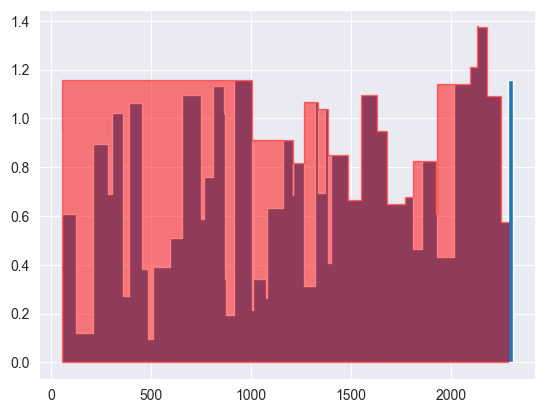

In [177]:
# 当窗口内到达的数据量超过可用的存储空间时，应做一定的取舍，既不突破内存限制，又尽可能保证结果的精确性
# 直观地看，当num_bins满载后，可以将num_bins分辨率降低，为新数据腾空间
# 降低分辨率涉及到合理的插值，是计算量较大的部分。考虑到这一点，如果每次仅将num_bins的数据插值到num_bins-1，那么每更新一次数据就要调用一次插值方法
# 为平衡插值效果与效率，通过实验的方法在模拟数据上比较不同压缩率的插值效果，确定一个基本合理的压缩率

# 以num_bins=50为例，模拟前50个数据的添加
np.random.seed(42)
test = MovingAverage(50,50)
timestamp = 0

for i in range(50):
    timestamp += np.random.randint(1, 100)
    price = i/100+(np.random.random())
    test.Update(timestamp, price)

# test.Vis()

# 相比于探究什么样的插值算法合适股价数据，这里直接使用numpy.interp作为示例
# 插值算法的效果关键在于如何选择插值点。由于实际数据可能出现数据间隔变化极端的情况，在原始时间范围内等间距选择插值点显然是不合适的
# 由于时间分辨率和价格分辨率均重要，受启发于点云数据下采样，这里设计基于复合指标的“最远点下采样法”，通过迭代的方式选取预设数量的插值时间点
# 效果远好于仅基于时间点的下采样法
before_timestamps = test.timestamps
before_prices = test.prices
# time_sparsity = before_timestamps[1:]-before_timestamps[:-1]
# symmetric_sparsity = time_sparsity[:-1]+time_sparsity[1:]
# start_timestamp_idx = np.argmin(symmetric_sparsity)+1
# start_timestamp = before_timestamps[start_timestamp_idx]
# 检查算法结果符合预期
# plt.plot(before_timestamps)
# plt.hlines(start_timestamp, 0, 50, colors="r", linewidth=3)

# 以num_kept=40为例，模拟插值后的结果
num_kept = 20

def farthest_point_sample_1d(timestamps, prices, start_idx, num_kept):
    kept_timestamps = np.zeros(num_kept)
    kept_compound = np.zeros(num_kept)
    compound = timestamps*prices
    
    kept_compound[[0,1]] = compound[start_idx]
    kept_timestamps[[0,1]] = timestamps[start_idx]
    print(timestamps)
    print(kept_timestamps)
    compound = np.delete(compound, start_idx)
    timestamps = np.delete(timestamps, start_idx)

    for i in range(1, num_kept):
        # distances = np.abs(compound-kept_compound[i-1])
        distances = np.abs(compound)
        # distances = np.abs(timestamps-kept_timestamps[i-1])
        # distances = np.abs(timestamps-np.median(timestamps))
        kept_timestamps[i] = timestamps[np.argmax(distances)]
        # kept_compound[i] = compound[np.argmax(distances)]
        timestamps = np.delete(timestamps, np.argmax(distances))
        compound = np.delete(compound, np.argmax(distances))
        # kept_timestamps[i] = timestamps[np.argmax(distances-np.median(distances))]
        # print(kept_timestamps)
        # print(timestamps[np.where(distances==np.median(distances))[0][0]])
        # compound = np.delete(compound, np.argmax(distances-np.median(distances)))
        # timestamps = np.delete(timestamps, np.argmax(distances-np.median(distances)))
        # break
        
    return np.sort(kept_timestamps)

# after_timestamps = farthest_point_sample_1d(before_timestamps, before_prices, start_timestamp_idx, num_kept)
after_timestamps = farthest_point_sample_1d(before_timestamps, before_prices, np.array([[0,-1]]), num_kept)
print(after_timestamps)
after_prices = np.interp(after_timestamps, before_timestamps, before_prices)

plt.fill_between(before_timestamps, before_prices, step="pre", alpha=1)
plt.fill_between(after_timestamps, after_prices, step="pre", alpha=0.5,color="r")

